## 1. Data Preparation

In [ ]:
import pandas as pd

In [ ]:
accounts_df = pd.read_csv("/content/synthetic_savings_accounts.csv")
transactions_df = pd.read_csv("/content/synthetic_savings_transactions.csv")

In [ ]:
accounts_df.head()

,account_id,account_number,account_type,description,opened_date,line_of_business,nickname,product_name,currency,current_balance
0,917cf271-6ad5-4cdd-b560-df614fbc8975,KUWH16222520094736,SAVINGS,STANDARD SAVINGS ACCOUNT,2020-04-13,Personal,VACATION FUND,PREMIUM SAVINGS,USD,6355.05
1,86a34dc9-068c-4b29-ae4d-d01bc4d9a4d9,NHTF95275394048160,SAVINGS,STANDARD SAVINGS ACCOUNT,2021-07-25,Personal,VACATION FUND,BASIC SAVINGS,USD,16592.03
2,8e7f76ae-2e52-4094-8ba8-814132e6dbcf,QOBO03117398822756,SAVINGS,STANDARD SAVINGS ACCOUNT,2016-05-20,Personal,EMERGENCY FUND,HIGH YIELD,USD,3701.70
3,c7a5178e-e9d6-4a6c-8566-1853f8703123,IQPF46632497390192,SAVINGS,STANDARD SAVINGS ACCOUNT,2019-05-22,Personal,SAVINGS,BASIC SAVINGS,USD,12702.32
4,6ecafba8-0278-4916-9656-3529f06be3cd,JANZ15079740508835,SAVINGS,STANDARD SAVINGS ACCOUNT,2023-07-01,Personal,VACATION FUND,HIGH YIELD,USD,1336.16


In [ ]:
transactions_df.head()

,transaction_id,account_id,transaction_date,post_date,description,transaction_type,amount,currency
0,2c2c0f19-bab5-482f-903d-8e82b5128eea,917cf271-6ad5-4cdd-b560-df614fbc8975,2023-09-25,2023-09-27,MAINTENANCE FEE,Fee,-12.58,USD
1,958a76a6-a8e3-48bf-b493-bfd6ac87ba2e,917cf271-6ad5-4cdd-b560-df614fbc8975,2024-05-08,2024-05-10,TRANSFER TO CHECKING,Transfer Out,-609.43,USD
2,c0845705-0353-42bf-88fd-3776efad5b63,917cf271-6ad5-4cdd-b560-df614fbc8975,2023-09-10,2023-09-12,ZELLE TO MARY,Transfer Out,-1441.07,USD
3,44b8ce9e-0e53-4e4b-8ba8-f980c49ffe18,917cf271-6ad5-4cdd-b560-df614fbc8975,2025-06-14,2025-06-16,MONTHLY SERVICE FEE,Fee,-23.91,USD
4,4b2669e7-91a7-4dbe-80b5-b50f3472362f,917cf271-6ad5-4cdd-b560-df614fbc8975,2024-08-17,2024-08-18,WIRE IN,Transfer In,1991.08,USD


In [ ]:
# Merge transactions and accounts data on account_id
merged_df = transactions_df.merge(accounts_df, on="account_id")

# Convert transaction_date to datetime format
# Any invalid date strings will be converted to NaT (Not a Time)
merged_df["transaction_date"] = pd.to_datetime(merged_df["transaction_date"], errors="coerce")

# Drop rows where transaction_date is invalid
merged_df = merged_df.dropna(subset=["transaction_date"])

# Extract year-month from transaction_date as a new column 'month'
merged_df["month"] = merged_df["transaction_date"].dt.to_period("M")

In [ ]:
merged_df.head()

,transaction_id,account_id,transaction_date,post_date,description_x,transaction_type,amount,currency_x,account_number,account_type,description_y,opened_date,line_of_business,nickname,product_name,currency_y,current_balance,month
0,2c2c0f19-bab5-482f-903d-8e82b5128eea,917cf271-6ad5-4cdd-b560-df614fbc8975,2023-09-25,2023-09-27,MAINTENANCE FEE,Fee,-12.58,USD,KUWH16222520094736,SAVINGS,STANDARD SAVINGS ACCOUNT,2020-04-13,Personal,VACATION FUND,PREMIUM SAVINGS,USD,6355.05,2023-09
1,958a76a6-a8e3-48bf-b493-bfd6ac87ba2e,917cf271-6ad5-4cdd-b560-df614fbc8975,2024-05-08,2024-05-10,TRANSFER TO CHECKING,Transfer Out,-609.43,USD,KUWH16222520094736,SAVINGS,STANDARD SAVINGS ACCOUNT,2020-04-13,Personal,VACATION FUND,PREMIUM SAVINGS,USD,6355.05,2024-05
2,c0845705-0353-42bf-88fd-3776efad5b63,917cf271-6ad5-4cdd-b560-df614fbc8975,2023-09-10,2023-09-12,ZELLE TO MARY,Transfer Out,-1441.07,USD,KUWH16222520094736,SAVINGS,STANDARD SAVINGS ACCOUNT,2020-04-13,Personal,VACATION FUND,PREMIUM SAVINGS,USD,6355.05,2023-09
3,44b8ce9e-0e53-4e4b-8ba8-f980c49ffe18,917cf271-6ad5-4cdd-b560-df614fbc8975,2025-06-14,2025-06-16,MONTHLY SERVICE FEE,Fee,-23.91,USD,KUWH16222520094736,SAVINGS,STANDARD SAVINGS ACCOUNT,2020-04-13,Personal,VACATION FUND,PREMIUM SAVINGS,USD,6355.05,2025-06
4,4b2669e7-91a7-4dbe-80b5-b50f3472362f,917cf271-6ad5-4cdd-b560-df614fbc8975,2024-08-17,2024-08-18,WIRE IN,Transfer In,1991.08,USD,KUWH16222520094736,SAVINGS,STANDARD SAVINGS ACCOUNT,2020-04-13,Personal,VACATION FUND,PREMIUM SAVINGS,USD,6355.05,2024-08


In [ ]:
# Group by account and month to calculate transaction statistics
monthly_stats = merged_df.groupby(["account_id", "month"]).agg({
    "amount": ["count", "sum"],
    "transaction_type": lambda x: (x == "Transfer Out").sum()
}).reset_index()

# Rename columns for clarity
monthly_stats.columns = ["account_id", "month", "txn_count", "total_amount", "transfer_out_count"]

In [ ]:
monthly_stats.head()

,account_id,month,txn_count,total_amount,transfer_out_count
0,00632750-c018-4455-badc-69b398fc9c70,2023-07,2,-23.39,0
1,00632750-c018-4455-badc-69b398fc9c70,2023-08,4,-759.75,1
2,00632750-c018-4455-badc-69b398fc9c70,2023-09,4,-792.75,0
3,00632750-c018-4455-badc-69b398fc9c70,2023-10,4,531.66,1
4,00632750-c018-4455-badc-69b398fc9c70,2023-11,1,-677.77,1


##  2. Tagged High-Risk Transactions Based on Rule Matching

This section identifies high-risk transactions based on predefined business rules tailored for savings accounts. The rules include unusually large transfers, frequent outgoing transactions in a single month, and monthly transfer totals exceeding specific thresholds.

By tagging transactions that match one or more risk conditions, we established a clear and interpretable baseline for high-risk behavior. These rule-based tags provide a transparent foundation for manual review and further risk analysis.

In [ ]:
# Filter transactions that are 'Transfer Out' and exceed 30% of current balance
rule1_df = merged_df[
    (merged_df["transaction_type"] == "Transfer Out") &
    (abs(merged_df["amount"]) > 0.3 * merged_df["current_balance"])
].copy()

# Add a new column to tag the risk rule
rule1_df["risk_rule"] = "R1: Transfer > 30% balance"

In [ ]:
rule1_df[["transaction_id", "account_id", "transaction_date", "amount", "current_balance", "risk_rule"]].head()

,transaction_id,account_id,transaction_date,amount,current_balance,risk_rule
161,fbe16424-fbf2-4217-a88d-d00c6ef2831c,8e7f76ae-2e52-4094-8ba8-814132e6dbcf,2023-10-17,-1156.54,3701.70,R1: Transfer > 30% balance
163,b41b0d48-b6dc-4e50-a975-97ae4c56a600,8e7f76ae-2e52-4094-8ba8-814132e6dbcf,2024-08-30,-1493.11,3701.70,R1: Transfer > 30% balance
232,8d409731-3df2-43c0-8cdd-1b56f33b5ec0,6ecafba8-0278-4916-9656-3529f06be3cd,2024-06-23,-1181.12,1336.16,R1: Transfer > 30% balance
234,c0a72728-d1de-405e-832d-b2cac9d2dda8,6ecafba8-0278-4916-9656-3529f06be3cd,2025-01-24,-1431.26,1336.16,R1: Transfer > 30% balance
235,4c5c857e-37de-4909-a395-2631a344357d,6ecafba8-0278-4916-9656-3529f06be3cd,2023-11-07,-819.34,1336.16,R1: Transfer > 30% balance


In [ ]:
# Rule R2: Find (account, month) where Transfer Out count >= 5
rule2_df = monthly_stats[monthly_stats["transfer_out_count"] >= 5].copy()
rule2_df["risk_rule"] = "R2: >=5 Transfer Out in month"

In [ ]:
rule2_df.head()

,account_id,month,txn_count,total_amount,transfer_out_count,risk_rule
9274,686841c5-c0b8-45f1-bef4-50e3beccebe0,2023-08,8,-2248.38,5,R2: >=5 Transfer Out in month
13656,9a4c517f-b132-47d5-af32-cb8d1b8e27d9,2024-01,6,-5388.11,5,R2: >=5 Transfer Out in month
14743,a43ea7cb-09b3-4750-9c43-37b9ea85c96b,2024-01,8,-1871.46,5,R2: >=5 Transfer Out in month
21843,fe919669-7875-452c-a110-6c174af297d2,2023-08,7,-4016.06,6,R2: >=5 Transfer Out in month


In [ ]:
# Rule R3: Find (account, month) where total outgoing amount > 3000
rule3_df = monthly_stats[monthly_stats["total_amount"] < -3000].copy()
rule3_df["risk_rule"] = "R3: Total Transfer Out > $3000"

In [ ]:
rule3_df.head()

,account_id,month,txn_count,total_amount,transfer_out_count,risk_rule
8,00632750-c018-4455-badc-69b398fc9c70,2024-03,6,-5007.95,1,R3: Total Transfer Out > $3000
43,00ab7686-03d3-409c-ab79-f27573c37687,2023-11,6,-3250.93,3,R3: Total Transfer Out > $3000
77,00d606d0-8426-481a-83bd-81833b5b6cef,2024-10,3,-3395.52,1,R3: Total Transfer Out > $3000
123,00f98dfd-f4c3-488d-81c7-487e66ebfaf5,2024-10,3,-3079.61,2,R3: Total Transfer Out > $3000
199,014de864-d774-494e-b335-84e6551d6ac5,2025-06,3,-3468.36,1,R3: Total Transfer Out > $3000


In [ ]:
# Match all transactions that happened in risky months of rule R2
r2_txns = merged_df.merge(rule2_df[["account_id", "month"]], on=["account_id", "month"])
r2_txns["risk_rule"] = "R2: >=5 Transfer Out in month"

In [ ]:
r2_txns[["transaction_id", "account_id", "transaction_date", "amount", "risk_rule"]].head()

,transaction_id,account_id,transaction_date,amount,risk_rule
0,afe5467e-6e8f-4921-9940-73ebececb2f8,9a4c517f-b132-47d5-af32-cb8d1b8e27d9,2024-01-29,-1080.19,R2: >=5 Transfer Out in month
1,8d49b6f5-de7c-4abe-b8db-1371c25be24b,9a4c517f-b132-47d5-af32-cb8d1b8e27d9,2024-01-14,-1477.79,R2: >=5 Transfer Out in month
2,2ac3d5e0-630e-4ab0-a483-a7c494a306b0,9a4c517f-b132-47d5-af32-cb8d1b8e27d9,2024-01-18,-284.23,R2: >=5 Transfer Out in month
3,3b7b2c6f-e030-466d-9779-12f1d56e23ec,9a4c517f-b132-47d5-af32-cb8d1b8e27d9,2024-01-01,-764.08,R2: >=5 Transfer Out in month
4,3228f798-bd53-4ec2-9115-f299211980b3,9a4c517f-b132-47d5-af32-cb8d1b8e27d9,2024-01-20,-965.90,R2: >=5 Transfer Out in month


In [ ]:
# Match all transactions that happened in risky months of rule R3
r3_txns = merged_df.merge(rule3_df[["account_id", "month"]], on=["account_id", "month"])
r3_txns["risk_rule"] = "R3: Total Transfer Out > $3000"

In [ ]:
r3_txns[["transaction_id", "account_id", "transaction_date", "amount", "risk_rule"]].head()

,transaction_id,account_id,transaction_date,amount,risk_rule
0,8994c2f7-f776-42d7-b736-284fdb47d0e9,86a34dc9-068c-4b29-ae4d-d01bc4d9a4d9,2024-12-23,-1175.97,R3: Total Transfer Out > $3000
1,24d83ba6-7995-45fb-a95d-6f9230b9e77d,86a34dc9-068c-4b29-ae4d-d01bc4d9a4d9,2024-07-03,-1152.48,R3: Total Transfer Out > $3000
2,c866d9ab-04ed-4b8b-9bb8-41110d205dec,86a34dc9-068c-4b29-ae4d-d01bc4d9a4d9,2024-12-23,-821.68,R3: Total Transfer Out > $3000
3,7259b8cd-bacd-41c0-ad14-55bbbd8c450e,86a34dc9-068c-4b29-ae4d-d01bc4d9a4d9,2024-12-02,-1025.03,R3: Total Transfer Out > $3000
4,3ae52f6a-f41c-4057-883b-05bde5a6db83,86a34dc9-068c-4b29-ae4d-d01bc4d9a4d9,2024-07-16,-1433.20,R3: Total Transfer Out > $3000


In [ ]:
# Combine all high risk transactions into one dataframe
high_risk_df = pd.concat([rule1_df, r2_txns, r3_txns], ignore_index=True)

# Remove duplicate entries if the same transaction is flagged by multiple rules
high_risk_df = high_risk_df.drop_duplicates(subset=["transaction_id", "risk_rule"])

In [ ]:
high_risk_df[["transaction_id", "account_id", "transaction_date", "amount", "transaction_type", "risk_rule"]].head()

,transaction_id,account_id,transaction_date,amount,transaction_type,risk_rule
0,fbe16424-fbf2-4217-a88d-d00c6ef2831c,8e7f76ae-2e52-4094-8ba8-814132e6dbcf,2023-10-17,-1156.54,Transfer Out,R1: Transfer > 30% balance
1,b41b0d48-b6dc-4e50-a975-97ae4c56a600,8e7f76ae-2e52-4094-8ba8-814132e6dbcf,2024-08-30,-1493.11,Transfer Out,R1: Transfer > 30% balance
2,8d409731-3df2-43c0-8cdd-1b56f33b5ec0,6ecafba8-0278-4916-9656-3529f06be3cd,2024-06-23,-1181.12,Transfer Out,R1: Transfer > 30% balance
3,c0a72728-d1de-405e-832d-b2cac9d2dda8,6ecafba8-0278-4916-9656-3529f06be3cd,2025-01-24,-1431.26,Transfer Out,R1: Transfer > 30% balance
4,4c5c857e-37de-4909-a395-2631a344357d,6ecafba8-0278-4916-9656-3529f06be3cd,2023-11-07,-819.34,Transfer Out,R1: Transfer > 30% balance


In [ ]:
high_risk_df.to_csv("high_risk_transactions.csv", index=False)

## 3. Transaction Risk Scoring Mechanism

Here, we introduce a numeric risk scoring system to quantify the severity of each transaction. Each matched rule (R1–R3) contributes to the overall score, helping prioritize transactions for investigation based on their risk weight.

The risk scoring mechanism complements the rule tags by enabling a gradient view of transaction risk. This helps prioritize the most suspicious activities and enables comparison across transactions or accounts.

In [ ]:
# Initialize all transactions with zero risk score
merged_df["risk_score"] = 0

# Rule R1: Transfer > 30% balance
r1_ids = rule1_df["transaction_id"].unique()
merged_df.loc[merged_df["transaction_id"].isin(r1_ids), "risk_score"] += 1

# Rule R2: >=5 transfer outs in one month
r2_ids = r2_txns["transaction_id"].unique()
merged_df.loc[merged_df["transaction_id"].isin(r2_ids), "risk_score"] += 1

# Rule R3: Total monthly transfer out > $3000
r3_ids = r3_txns["transaction_id"].unique()
merged_df.loc[merged_df["transaction_id"].isin(r3_ids), "risk_score"] += 1

In [ ]:
# Show transactions with risk_score > 0
high_score_df = merged_df[merged_df["risk_score"] > 0]

# Preview top risky transactions
high_score_df[["transaction_id", "account_id", "transaction_date", "amount", "transaction_type", "risk_score"]].sort_values(by="risk_score", ascending=False).head()

,transaction_id,account_id,transaction_date,amount,transaction_type,risk_score
56585,9041815e-cab6-4347-99e5-521b7e45071b,fe919669-7875-452c-a110-6c174af297d2,2023-08-30,282.21,Deposit,2
56596,9fe7112b-d18f-4a0e-8b79-ed0d7c709d29,fe919669-7875-452c-a110-6c174af297d2,2023-08-13,-251.06,Transfer Out,2
56602,3381f2c2-6dbd-4362-84fe-84c81acaceea,fe919669-7875-452c-a110-6c174af297d2,2023-08-15,-1466.27,Transfer Out,2
39660,ad6bf97e-5435-4ca2-acfd-f165044c865f,dc8b1ce6-8abd-4ba0-86f0-f81838a7f8a7,2024-11-26,-1417.75,Transfer Out,2
39649,3f739104-5af1-490c-b5b1-180d9a9973ec,dc8b1ce6-8abd-4ba0-86f0-f81838a7f8a7,2024-11-10,-1487.33,Transfer Out,2


## 4. Account-Level Risk Aggregation

In this section, we aggregate risk scores from individual transactions to the account level. This helps identify which accounts consistently exhibit risky behavior based on cumulative risk signals.

Account-level risk summaries provide a powerful tool for surfacing persistently risky accounts. With features like total risk score, high-risk transaction count, and labeled risk levels, we can effectively triage which customers warrant closer monitoring.

In [ ]:
# Group by account to summarize transaction risk
account_risk_summary = merged_df.groupby("account_id").agg({
    "risk_score": ["sum", "mean", lambda x: (x > 0).sum()],
    "transaction_id": "count"
}).reset_index()

# Rename columns
account_risk_summary.columns = [
    "account_id",
    "total_risk_score",
    "avg_risk_score",
    "high_risk_txn_count",
    "total_txn_count"
]

# Sort by total risk score descending
account_risk_summary = account_risk_summary.sort_values(by="total_risk_score", ascending=False)

In [ ]:
account_risk_summary.head(10)

,account_id,total_risk_score,avg_risk_score,high_risk_txn_count,total_txn_count
102,1b2152af-7100-4d93-b9f5-40009aaa06d1,23,0.230000,21,100
188,3004a96f-0263-4f16-a868-43db62855507,22,0.224490,20,98
136,235ef071-5a95-4919-99a6-b7bb839e52ec,21,0.228261,17,92
88,17dea902-8835-4b45-aa5a-0bc920789b1a,21,0.265823,21,79
481,77230db6-6d74-42bc-8357-48e1c2ab4b2b,20,0.235294,18,85
356,57e6ada0-85d6-4e21-bea3-73073a8d6db1,20,0.215054,17,93
112,1d1a35e5-86c6-4d6e-8dff-3096ee70ef67,19,0.218391,16,87
746,b93a325c-6030-4a05-a7ae-a24848551a42,19,0.260274,16,73
452,6fd9d11a-3061-4008-aa1c-a29621b23617,19,0.202128,16,94
532,86c49bd6-aed3-4258-8e51-60ca6e8b1d35,17,0.191011,15,89


In [ ]:
# Set risk threshold
risk_threshold = 3

# Add a new column to label risk level
account_risk_summary["risk_level"] = account_risk_summary["total_risk_score"].apply(
    lambda x: "High Risk" if x > risk_threshold else "Low Risk"
)

In [ ]:
account_risk_summary.head()

,account_id,total_risk_score,avg_risk_score,high_risk_txn_count,total_txn_count,risk_level
102,1b2152af-7100-4d93-b9f5-40009aaa06d1,23,0.230000,21,100,High Risk
188,3004a96f-0263-4f16-a868-43db62855507,22,0.224490,20,98,High Risk
136,235ef071-5a95-4919-99a6-b7bb839e52ec,21,0.228261,17,92,High Risk
88,17dea902-8835-4b45-aa5a-0bc920789b1a,21,0.265823,21,79,High Risk
481,77230db6-6d74-42bc-8357-48e1c2ab4b2b,20,0.235294,18,85,High Risk


In [ ]:
account_risk_summary["risk_level"].value_counts()

,count
risk_level,
Low Risk,735
High Risk,265


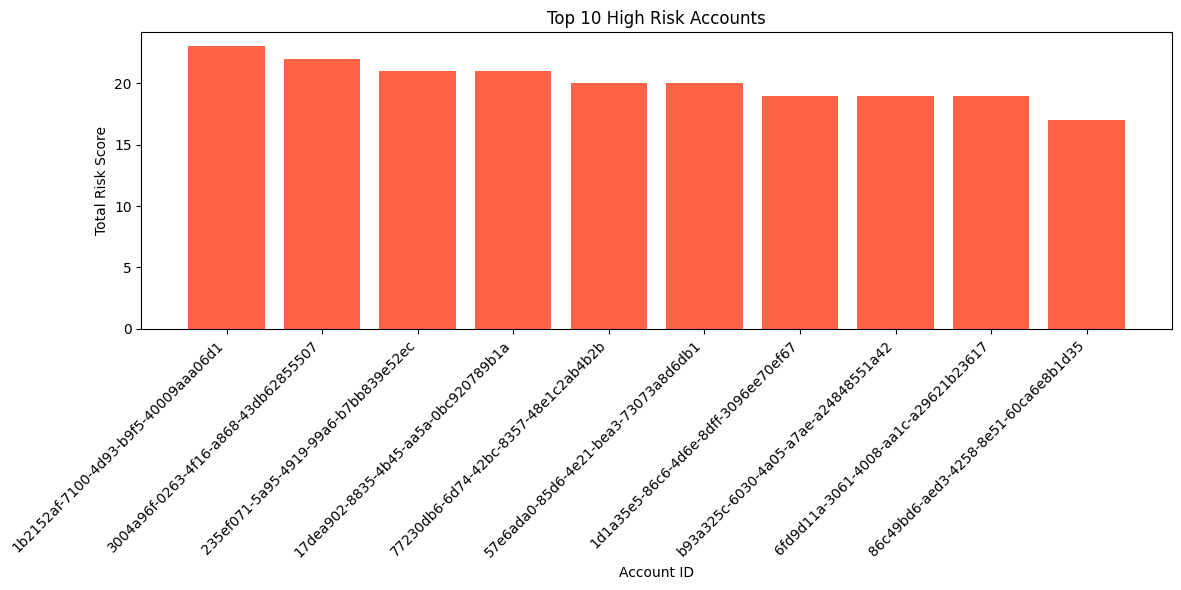

In [ ]:
import matplotlib.pyplot as plt

# Select top N risky accounts
top_n = 10
top_accounts = account_risk_summary.head(top_n)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_accounts["account_id"], top_accounts["total_risk_score"], color="tomato")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Account ID")
plt.ylabel("Total Risk Score")
plt.title(f"Top {top_n} High Risk Accounts")
plt.tight_layout()
plt.show()


## 5. Unsupervised Anomaly Detection

To identify hidden risks beyond human-defined rules, this section applies machine learning—specifically, Isolation Forest—for unsupervised anomaly detection. It learns patterns from account behaviors and flags outliers as potential anomalies.

The anomaly detection model revealed accounts with unusual transaction behavior that rule-based systems missed. By combining model-based and rule-based perspectives, we achieved a more holistic and robust approach to high-risk account detection.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Step 1: Select features
features = ["total_risk_score", "avg_risk_score", "high_risk_txn_count", "total_txn_count"]
X = account_risk_summary[features].copy()

# Step 2: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Fit Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
account_risk_summary["anomaly_score"] = model.fit_predict(X_scaled)

# Step 4: Label anomalies
# -1 means anomaly, 1 means normal
account_risk_summary["anomaly_label"] = account_risk_summary["anomaly_score"].apply(
    lambda x: "Anomalous" if x == -1 else "Normal"
)

In [ ]:
account_risk_summary[account_risk_summary["anomaly_label"] == "Anomalous"].head(10)

,account_id,total_risk_score,avg_risk_score,high_risk_txn_count,total_txn_count,risk_level,anomaly_score,anomaly_label
102,1b2152af-7100-4d93-b9f5-40009aaa06d1,23,0.230000,21,100,High Risk,-1,Anomalous
188,3004a96f-0263-4f16-a868-43db62855507,22,0.224490,20,98,High Risk,-1,Anomalous
136,235ef071-5a95-4919-99a6-b7bb839e52ec,21,0.228261,17,92,High Risk,-1,Anomalous
88,17dea902-8835-4b45-aa5a-0bc920789b1a,21,0.265823,21,79,High Risk,-1,Anomalous
481,77230db6-6d74-42bc-8357-48e1c2ab4b2b,20,0.235294,18,85,High Risk,-1,Anomalous
356,57e6ada0-85d6-4e21-bea3-73073a8d6db1,20,0.215054,17,93,High Risk,-1,Anomalous
112,1d1a35e5-86c6-4d6e-8dff-3096ee70ef67,19,0.218391,16,87,High Risk,-1,Anomalous
746,b93a325c-6030-4a05-a7ae-a24848551a42,19,0.260274,16,73,High Risk,-1,Anomalous
452,6fd9d11a-3061-4008-aa1c-a29621b23617,19,0.202128,16,94,High Risk,-1,Anomalous
532,86c49bd6-aed3-4258-8e51-60ca6e8b1d35,17,0.191011,15,89,High Risk,-1,Anomalous


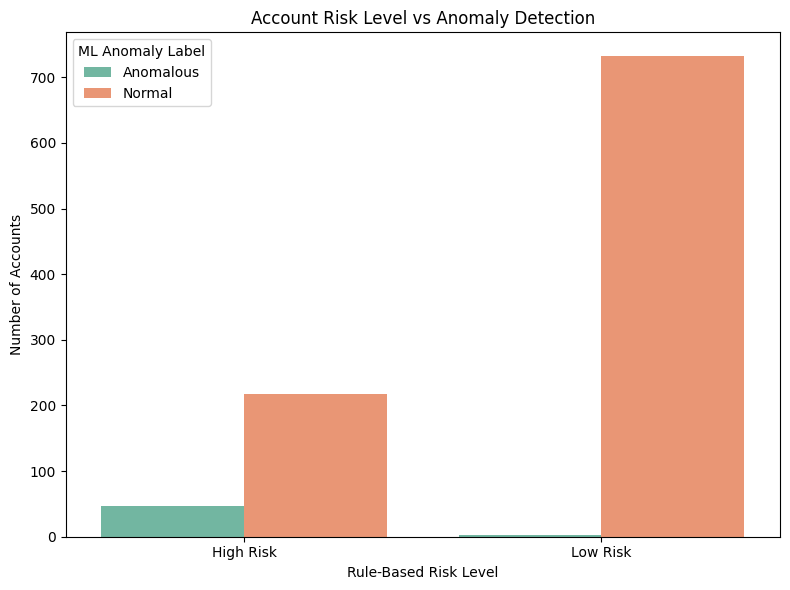

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot grouped by risk level and anomaly label
plt.figure(figsize=(8, 6))
sns.countplot(
    data=account_risk_summary,
    x="risk_level",
    hue="anomaly_label",
    palette="Set2"
)

plt.title("Account Risk Level vs Anomaly Detection")
plt.xlabel("Rule-Based Risk Level")
plt.ylabel("Number of Accounts")
plt.legend(title="ML Anomaly Label")
plt.tight_layout()
plt.show()


In [ ]:
super_risky = account_risk_summary[
    (account_risk_summary["risk_level"] == "High Risk") &
    (account_risk_summary["anomaly_label"] == "Anomalous")
]

super_risky.head()

,account_id,total_risk_score,avg_risk_score,high_risk_txn_count,total_txn_count,risk_level,anomaly_score,anomaly_label
102,1b2152af-7100-4d93-b9f5-40009aaa06d1,23,0.230000,21,100,High Risk,-1,Anomalous
188,3004a96f-0263-4f16-a868-43db62855507,22,0.224490,20,98,High Risk,-1,Anomalous
136,235ef071-5a95-4919-99a6-b7bb839e52ec,21,0.228261,17,92,High Risk,-1,Anomalous
88,17dea902-8835-4b45-aa5a-0bc920789b1a,21,0.265823,21,79,High Risk,-1,Anomalous
481,77230db6-6d74-42bc-8357-48e1c2ab4b2b,20,0.235294,18,85,High Risk,-1,Anomalous


In [ ]:
hidden_risk = account_risk_summary[
    (account_risk_summary["risk_level"] == "Low Risk") &
    (account_risk_summary["anomaly_label"] == "Anomalous")
]

hidden_risk.head()

,account_id,total_risk_score,avg_risk_score,high_risk_txn_count,total_txn_count,risk_level,anomaly_score,anomaly_label
616,98a4c12c-8661-4285-afc2-af0788c8d0d5,2,0.021053,2,95,Low Risk,-1,Anomalous
322,4dc79534-d57c-45d2-b652-9002b8df3ecd,2,0.066667,2,30,Low Risk,-1,Anomalous
814,cbe7002e-68ca-49e5-b9fb-df0ac2b8c230,1,0.030303,1,33,Low Risk,-1,Anomalous


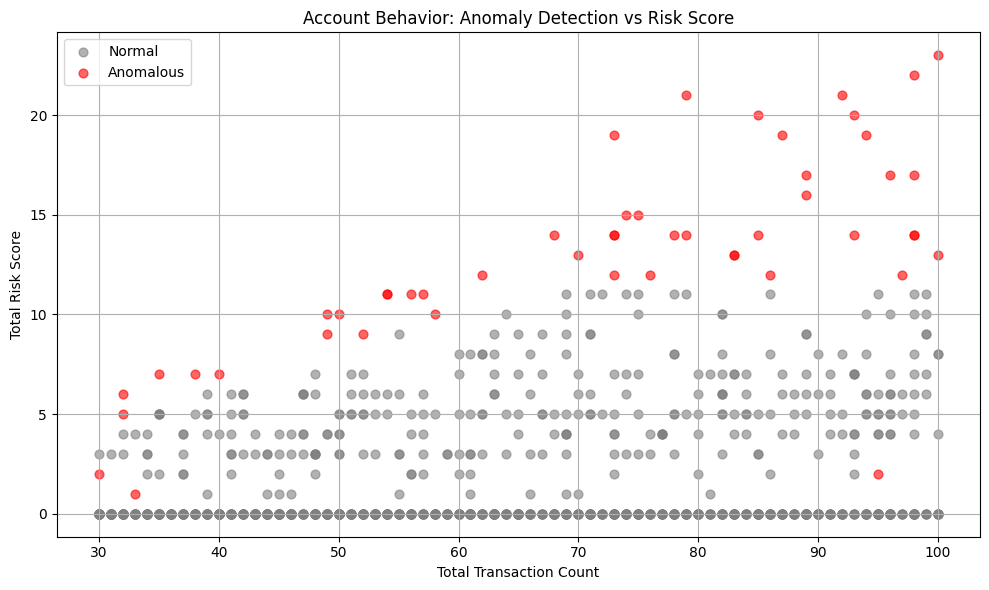

In [ ]:
import matplotlib.pyplot as plt

# Plot: Total Risk Score vs. Transaction Count
plt.figure(figsize=(10, 6))
for label, color in [("Normal", "gray"), ("Anomalous", "red")]:
    subset = account_risk_summary[account_risk_summary["anomaly_label"] == label]
    plt.scatter(
        subset["total_txn_count"],
        subset["total_risk_score"],
        label=label,
        alpha=0.6,
        s=40,
        c=color
    )

plt.xlabel("Total Transaction Count")
plt.ylabel("Total Risk Score")
plt.title("Account Behavior: Anomaly Detection vs Risk Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Sequential Transaction Pattern Mining

This section explores the behavioral sequences of savings account transactions using sliding window analysis. By treating each account’s transaction history as a time-ordered sequence, we extract and quantify recurring 3-step patterns (e.g., "Transfer In → Fee → Transfer Out"). These patterns provide insights into typical and potentially suspicious transaction flows, such as deposit-then-drain or fee-induced inactivity behaviors.

Sequential pattern mining allows us to uncover frequent transaction flows that might not appear suspicious individually but reveal risky behavior when viewed in order. This technique is particularly powerful in exposing structured fraud patterns or automated attack behaviors that operate through specific transaction sequences.

In [ ]:
from collections import Counter
from itertools import islice

# Step 1: group transactions per account by date
merged_df_sorted = merged_df.sort_values(by=["account_id", "transaction_date"])
grouped = merged_df_sorted.groupby("account_id")["transaction_type"].apply(list)

# Step 2: extract 3-transaction sliding patterns
def sliding_windows(seq, n=3):
    return [tuple(seq[i:i+n]) for i in range(len(seq)-n+1)]

# Step 3: count all patterns
all_patterns = []
for txns in grouped:
    if len(txns) >= 3:
        all_patterns.extend(sliding_windows(txns, 3))

pattern_counts = Counter(all_patterns)

In [ ]:
pattern_counts.most_common(10)

[(('Deposit', 'Withdrawal', 'Fee'), 344),
 (('Deposit', 'Fee', 'Transfer Out'), 341),
 (('Withdrawal', 'Transfer In', 'Fee'), 337),
 (('Withdrawal', 'Deposit', 'Withdrawal'), 333),
 (('Transfer In', 'Fee', 'Withdrawal'), 329),
 (('Withdrawal', 'Transfer Out', 'Transfer Out'), 326),
 (('Transfer In', 'Fee', 'Fee'), 326),
 (('Withdrawal', 'Withdrawal', 'Transfer In'), 324),
 (('Withdrawal', 'Transfer In', 'Interest Credit'), 321),
 (('Transfer In', 'Transfer In', 'Deposit'), 320)]

## 7. Extract High-Risk Account Transaction Patterns

In [ ]:
from collections import Counter

# Function to extract sliding windows of n elements from a list
def sliding_windows(seq, n=3):
    return [tuple(seq[i:i+n]) for i in range(len(seq)-n+1)]

# Step 1: Get list of high-risk account IDs
high_risk_accounts = account_risk_summary[
    account_risk_summary["risk_level"] == "High Risk"
]["account_id"]

# Step 2: Filter and group transactions for high-risk accounts
high_risk_grouped = merged_df_sorted[
    merged_df_sorted["account_id"].isin(high_risk_accounts)
].groupby("account_id")["transaction_type"].apply(list)

# Step 3: Extract 3-step sequences for high-risk accounts
hr_patterns = []
for txns in high_risk_grouped:
    if len(txns) >= 3:
        hr_patterns.extend(sliding_windows(txns, 3))

# Step 4: Count pattern frequencies
hr_pattern_counts = Counter(hr_patterns)

from collections import Counter

# Step 5: Get list of low-risk account IDs
normal_accounts = account_risk_summary[
    account_risk_summary["risk_level"] == "Low Risk"
]["account_id"]

# Step 6: Group transactions for low-risk accounts
normal_grouped = merged_df_sorted[
    merged_df_sorted["account_id"].isin(normal_accounts)
].groupby("account_id")["transaction_type"].apply(list)

# Step 7: Extract 3-step sequences for low-risk accounts
normal_patterns = []
for txns in normal_grouped:
    if len(txns) >= 3:
        normal_patterns.extend(sliding_windows(txns, 3))

# Step 8: Count pattern frequencies for low-risk group
normal_pattern_counts = Counter(normal_patterns)

# Step 9: Keep patterns that are common in high-risk accounts,
# but either rare or nonexistent in low-risk (<= 3 times)
unique_high_risk_patterns = {
    pattern: count for pattern, count in hr_pattern_counts.items()
    if normal_pattern_counts.get(pattern, 0) <= 3
}


In [ ]:
unique_high_risk_patterns

{}

No 3-step patterns were found to be exclusive to high-risk accounts. This is likely because transaction_type is too general, leading to overlap across all accounts. High- and low-risk accounts may share similar behaviors under the current rules.

Instead of filtering out all patterns seen in low-risk accounts, we now look for patterns that are much more frequent in high-risk accounts. These "dominant" patterns can still signal risk even if they appear occasionally elsewhere.

In [ ]:
# Step 1: Compare pattern frequency in high-risk vs low-risk
pattern_diff = []

for pattern, hr_count in hr_pattern_counts.items():
    normal_count = normal_pattern_counts.get(pattern, 0)
    diff = hr_count - normal_count
    pattern_diff.append((pattern, hr_count, normal_count, diff))

# Step 2: Convert to DataFrame
pattern_diff_df = pd.DataFrame(
    pattern_diff,
    columns=["Pattern", "HighRiskCount", "LowRiskCount", "FrequencyDelta"]
)

# Step 3: Sort by descending difference
pattern_diff_df = pattern_diff_df.sort_values(by="FrequencyDelta", ascending=False)

# Step 4: Show top 20 dominant patterns in high-risk accounts
pattern_diff_df.head(20)

,Pattern,HighRiskCount,LowRiskCount,FrequencyDelta
171,"(Transfer Out, Transfer Out, Transfer Out)",114,145,-31
8,"(Withdrawal, Withdrawal, Transfer Out)",117,170,-53
76,"(Transfer Out, Withdrawal, Transfer Out)",106,161,-55
80,"(Transfer Out, Transfer Out, Interest Credit)",104,162,-58
174,"(Interest Credit, Withdrawal, Withdrawal)",111,174,-63
192,"(Withdrawal, Fee, Transfer Out)",113,181,-68
28,"(Transfer Out, Withdrawal, Withdrawal)",108,176,-68
75,"(Transfer Out, Transfer Out, Withdrawal)",122,195,-73
132,"(Transfer Out, Transfer Out, Fee)",104,177,-73
15,"(Withdrawal, Withdrawal, Withdrawal)",108,181,-73


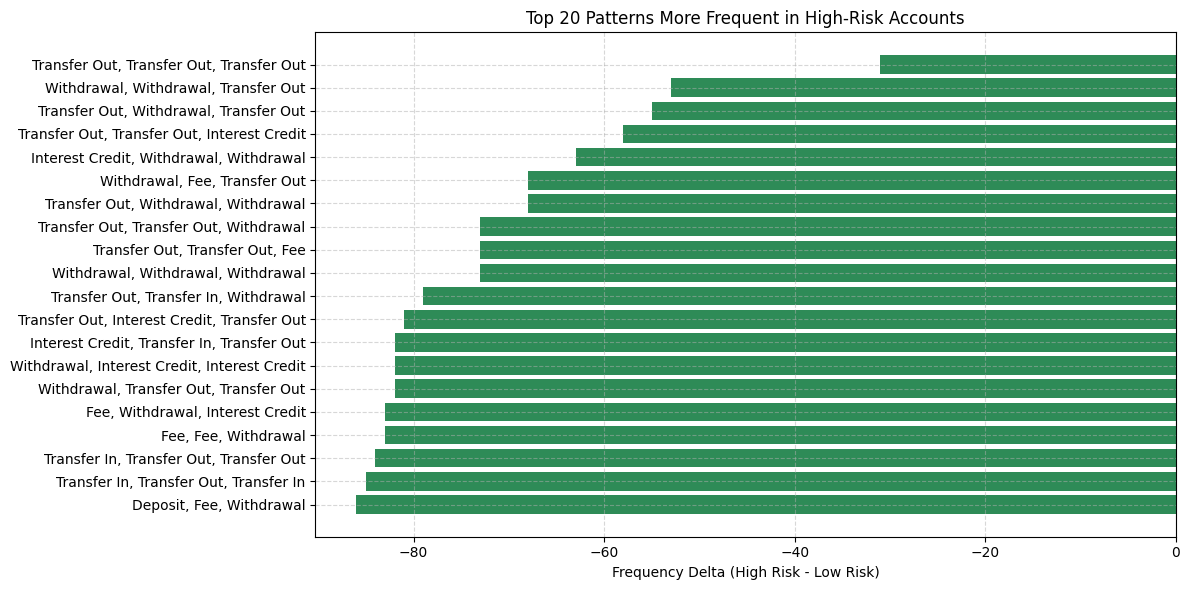

In [ ]:
top_dominant_patterns = pattern_diff_df.head(20)

pattern_labels = [", ".join(p) for p in top_dominant_patterns["Pattern"]]

plt.figure(figsize=(12, 6))
plt.barh(pattern_labels, top_dominant_patterns["FrequencyDelta"], color="seagreen")
plt.xlabel("Frequency Delta (High Risk - Low Risk)")
plt.title("Top 20 Patterns More Frequent in High-Risk Accounts")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

These 3-step transaction patterns appear more frequently in high-risk accounts, suggesting that repeated actions like "Transfer Out" and "Withdrawal" may signal risk-prone behavior. The presence of fees and interest credits in these sequences may also reflect unusual or system-driven activity, making these patterns useful indicators for identifying high-risk account behavior.

## 8. Prototype

interactive(children=(IntSlider(value=3, description='Risk Score ≥', max=10), IntSlider(value=10, description=…

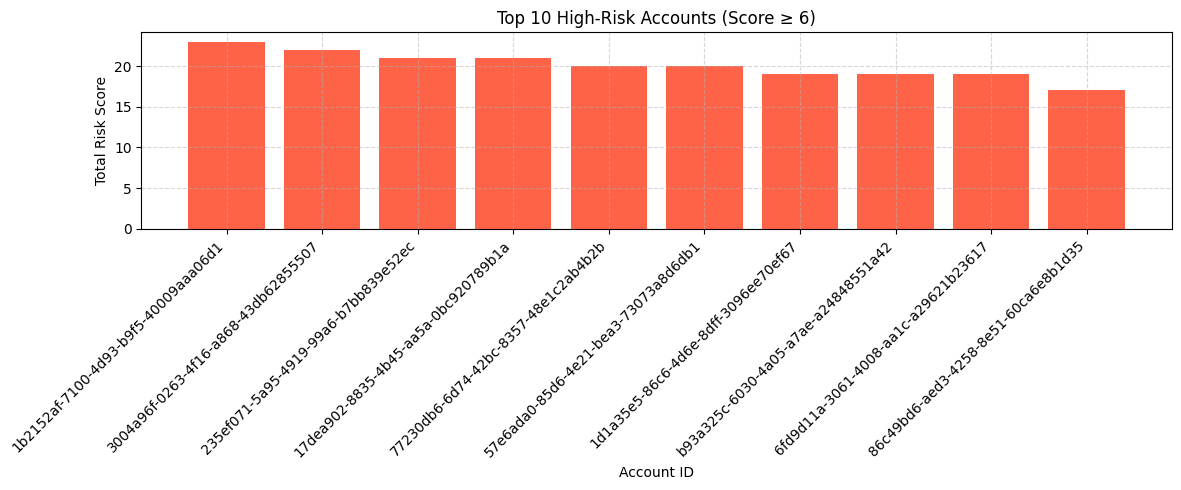

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import pandas as pd

def show_top_risk_accounts(threshold=3, top_n=10):
    filtered = account_risk_summary[account_risk_summary["total_risk_score"] >= threshold]
    top_accounts = filtered.sort_values(by="total_risk_score", ascending=False).head(top_n)

    plt.figure(figsize=(12, 5))
    plt.bar(top_accounts["account_id"], top_accounts["total_risk_score"], color="tomato")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Account ID")
    plt.ylabel("Total Risk Score")
    plt.title(f"Top {top_n} High-Risk Accounts (Score ≥ {threshold})")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

interact(
    show_top_risk_accounts,
    threshold=widgets.IntSlider(value=3, min=0, max=10, step=1, description="Risk Score ≥"),
    top_n=widgets.IntSlider(value=10, min=5, max=30, step=1, description="Top N Accounts")
)

In [ ]:
def view_account_transactions(account_id):
    df = merged_df[merged_df["account_id"] == account_id].copy()
    df = df[df["risk_score"] > 0]
    display(df[[
        "transaction_id", "transaction_date", "amount", "transaction_type", "risk_score"
    ]].sort_values(by="transaction_date"))

high_risk_accounts = account_risk_summary[
    account_risk_summary["risk_level"] == "High Risk"
]["account_id"].unique()

account_dropdown = widgets.Dropdown(
    options=high_risk_accounts,
    description="Account ID:",
    style={"description_width": "initial"}
)

interact(view_account_transactions, account_id=account_dropdown)

interactive(children=(Dropdown(description='Account ID:', options=('1b2152af-7100-4d93-b9f5-40009aaa06d1', '30…

<function __main__.view_account_transactions(account_id)>